In [1]:
%load_ext autoreload
%autoreload 2

from text3d2video.artifacts.anim_artifact import AnimationArtifact
import torch

torch.set_grad_enabled(False)

anim = AnimationArtifact.from_wandb_artifact_tag('mv_helmet:latest')
seq = anim.read_anim_seq()

In [83]:
from text3d2video.rendering import make_mesh_rasterizer


rasterizer = make_mesh_rasterizer()

frame_i = 2

cam = seq.cams[frame_i]
mesh = seq.meshes[frame_i]
verts_uvs = seq.verts_uvs
faces_uvs = seq.faces_uvs

frags = rasterizer(mesh, cameras=cam)

In [84]:
faces = mesh.faces_list()[0]
verts = mesh.verts_list()[0]

vert_normals = mesh.verts_normals_list()[0]
face_vert_normals = vert_normals[faces]

print("V", len(verts))
print("F", len(faces))


V 2225
F 2346


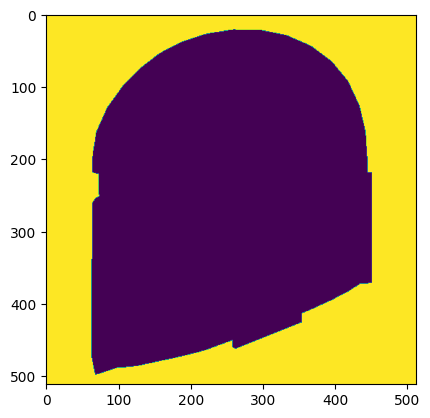

In [96]:
from matplotlib import pyplot as plt


bg_mask = (frags.zbuf < 0)[0,:,:,0]

plt.imshow(bg_mask.cpu())

In [85]:
from einops import rearrange
from pytorch3d.ops import interpolate_face_attributes

pixel_normals = interpolate_face_attributes(
    frags.pix_to_face, frags.bary_coords, face_vert_normals
)

pixel_normals = rearrange(pixel_normals, "1 h w 1 c -> h w c")

In [99]:
import torchvision.transforms.functional as TF
import torch

from text3d2video.utilities.ipython_utils import display_ims

res = 512

x = torch.linspace(-1, 1, res)
y = torch.linspace(-1, 1, res)
grid_y, grid_x = torch.meshgrid(y, x, indexing="ij")
pixels_ndc = torch.stack([grid_x, grid_y, -torch.ones_like(grid_x)], dim=-1)  # (H, W, 3)

view_dirs = torch.nn.functional.normalize(pixels_ndc, dim=-1).cuda()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999962..0.70710605].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9932314..1.0000001].


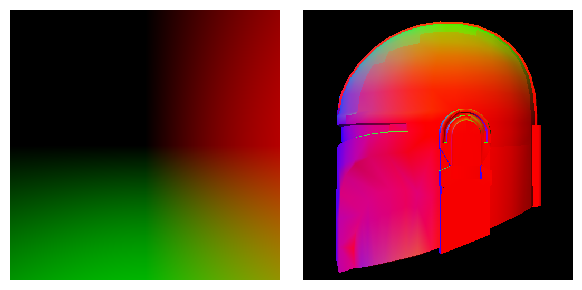

In [100]:
display_ims([view_dirs.cpu(), pixel_normals.cpu()])

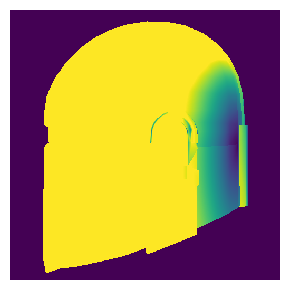

In [105]:
cos_theta = (view_dirs * pixel_normals).sum(dim=-1).clamp(-1.0, 1.0)  # (H, W)
theta = torch.acos(cos_theta)  # (H, W)

theta[bg_mask] = 0 

display_ims([theta.cpu()], vmin=0, vmax=1)

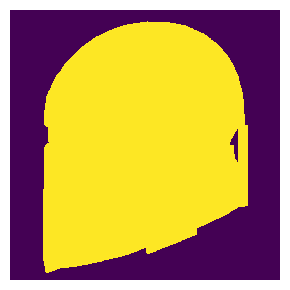

In [115]:
from matplotlib import pyplot as plt


mask = theta > 0.1

display_ims([mask.cpu()], vmin=0, vmax=1)

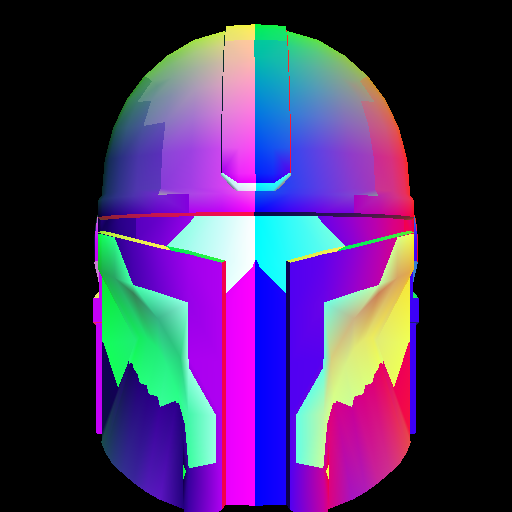

In [24]:


TF.to_pil_image(pixel_normals[0].cpu())